In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import cv2, os, tensorflow, keras
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
from skimage import color
from google.colab.patches import cv2_imshow
import albumentations as A
from scipy.io import savemat
import scipy.io as sio
from numpy import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPooling2D, Activation, Reshape, MaxPool2D, UpSampling2D, Add
from tensorflow.keras import Input, Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, classification_report, accuracy_score
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
import pickle

In [3]:
'''#2880: number of images
#256: ydim
#128: xdim'''
IMGfile=pickle.load(open('/content/drive/MyDrive/VERTEBRAS/Copy of Fimg2880_denoise_hist.pickle','rb'))
imgA=np.asarray(IMGfile)
print(imgA.shape)

(2880, 128, 64)


In [4]:
'''#2880: number of images 
#68: Total landmark points
#2: x & y coprdinates'''
KPfile=pickle.load(open('/content/drive/MyDrive/VERTEBRAS/Copy of Fkp1500_denoise_hist.pickle','rb'))
kpA=np.asarray(KPfile)
print(kpA.shape)

(2880, 68, 2)


In [5]:
#imgRESNET50 = preprocess_input(imgA)
imgA_expand_dim=np.repeat(np.expand_dims(imgA, axis=3), 3, axis=3)
print(imgA_expand_dim.shape)

(2880, 128, 64, 3)


### Applying the Bayesian Optimizer to get optimal hyperparameters

In [6]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.3 MB/s eta 0:00:00


In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from bayes_opt import BayesianOptimization
from hyperopt.pyll.base import scope 
#quniform returns float, some parameters require int; use this to force int
space = {'optimizers'  : hp.choice('optimizers', ['SGD', 'adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam']),
         'batch_size' : hp.choice('batch_size',np.array([2**i for i in range(4, 10)])),
         'epochs'     : hp.choice('epochs',np.array([i for i in range(50, 301, 50)])),
         'loss'       : hp.choice('loss', ['mse', 'mae', 'mean_squared_logarithmic_error'])
         }

In [ ]:
def f_nn(params):
  #model=Sequential()
  #inputs = Input(shape=(Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3]))
  inputs = Input(shape=(128, 64,3))
  #Layer1
  modelearn = ResNet101(include_top=False, input_tensor=inputs, weights='imagenet', pooling='avg')
  x8=Dense(136)((modelearn.layers[-1].output))
  x10=Reshape((68,2))(x8)                               
  model = Model(inputs=inputs, outputs= x10)
  
  model.compile(optimizer=params['optimizers'], loss=params['loss'], metrics=['accuracy'])
  result=model.fit(imgA_expand_dim, kpA, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.33)

  validation_acc = np.amax(result.history['val_accuracy']) 
  print('Best validation accuracy of epoch:', validation_acc)
    
  return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model, 'params': params}
trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=5, trials=trials)


Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 6s 2s/step - loss: 9.5132 - accuracy: 0.9461 - val_loss: 37.2074 - val_accuracy: 0.8126

Epoch 110/300

4/4 [==============================] - 6s 2s/step - loss: 8.9715 - accuracy: 0.9473 - val_loss: 37.3828 - val_accuracy: 0.8174

Epoch 111/300

4/4 [==============================] - 6s 2s/step - loss: 9.1215 - accuracy: 0.9483 - val_loss: 36.9767 - val_accuracy: 0.8232

Epoch 112/300

4/4 [==============================] - 6s 2s/step - loss: 8.6540 - accuracy: 0.9505 - val_loss: 36.7556 - val_accuracy: 0.8276

Epoch 113/300

4/4 [==============================] - 6s 2s/step - loss: 8.8238 - accuracy: 0.9509 - val_loss: 35.9992 - val_accuracy: 0.8493

Epoch 114/300

4/4 [==============================] - 6s 2s/step - loss: 8.6172 - accuracy: 0.9509 - val_loss: 35.4882 - val_accuracy: 0.8608

Epoch 115/300

4/4 [==============================] - 6s 2s/step - loss: 8.4301 - accuracy: 0.9521 - val_l

In [ ]:
print("Best: {}".format(best))


### Training the model

In [8]:
imgShape=Input(shape=(imgA_expand_dim.shape[1], imgA_expand_dim.shape[2], imgA_expand_dim.shape[3]))
modelearn = ResNet101(include_top=False, input_tensor=imgShape, pooling='avg')
'''x1=Flatten()(modelearn.layers[-1].output)
x2=Dense(4096)(x1)
x3=Dropout(0.8)(x2)
x4=Dense(512)(x3)
x5=Dropout(0.25)((modelearn.layers[-1].output))
x6=Dense(256)(x5)
x7=Dropout(0.25)(x6)'''
x8=Dense(136)(modelearn.layers[-1].output)
#x9=Dropout(0.25)(x8)
x10=Reshape((68,2))(x8)
# define new model
model = Model(inputs=imgShape, outputs=x10)
model.compile(optimizer='Adamax', loss='mse', metrics=['accuracy'])
model.summary()

171446536/171446536 [==============================] - 8s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizati

In [9]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1)
trainModel=model.fit(imgA_expand_dim, kpA, epochs=300, batch_size=8, validation_split=0.33)#, callbacks=es)

Epoch 1/300
242/242 [==============================] - 43s 95ms/step - loss: 285.1699 - accuracy: 0.9019 - val_loss: 151.3882 - val_accuracy: 0.9537
Epoch 2/300
242/242 [==============================] - 20s 83ms/step - loss: 45.1067 - accuracy: 0.9537 - val_loss: 80.4709 - val_accuracy: 0.9537
Epoch 3/300
242/242 [==============================] - 20s 84ms/step - loss: 44.9171 - accuracy: 0.9557 - val_loss: 72.1168 - val_accuracy: 0.9478
Epoch 4/300
242/242 [==============================] - 20s 84ms/step - loss: 35.5855 - accuracy: 0.9606 - val_loss: 38.9688 - val_accuracy: 0.9618
Epoch 5/300
242/242 [==============================] - 21s 86ms/step - loss: 30.3683 - accuracy: 0.9624 - val_loss: 48.1539 - val_accuracy: 0.9634
Epoch 6/300
242/242 [==============================] - 21s 85ms/step - loss: 26.8248 - accuracy: 0.9645 - val_loss: 24.6764 - val_accuracy: 0.9697
Epoch 7/300
242/242 [==============================] - 21s 85ms/step - loss: 22.4772 - accuracy: 0.9668 - val_loss: 

In [20]:
'''model.save("/content/drive/MyDrive/VERTEBRAS/Model_denoise_hist_e300_resnet101_b8.h5")
print("model saved!!!")'''
model = tensorflow.keras.models.load_model("/content/drive/MyDrive/VERTEBRAS/Model_denoise_hist_e300_resnet101_b8.h5")
print('SAVVVVVVVed')

model saved!!!
SAVVVVVVVed


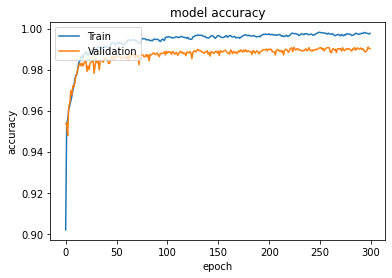

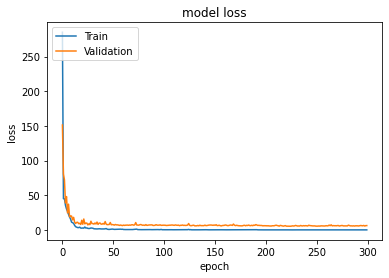

In [10]:
plt.plot(trainModel.history['accuracy'])
plt.plot(trainModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trainModel.history['loss'])
plt.plot(trainModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
Ypred=model.predict(imgA_expand_dim[591:592])

1/1 [==============================] - 2s 2s/step


In [ ]:
Ypred.shape

(1, 68, 2)

In [ ]:
x=Ypred[0,:][:,0]
y=Ypred[0,:][:,1]

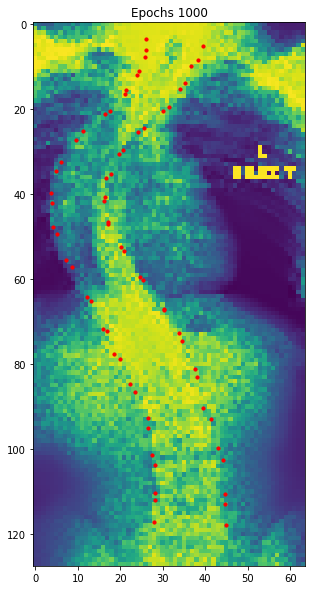

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Epochs 1000')
plt.imshow(imgA[591])
plt.scatter(x,y, color='red', s=10)

In [11]:
IMGfile=pickle.load(open('/content/drive/MyDrive/VERTEBRAS/Copy of TEST_Fimg128.pickle','rb'))
imgTest=np.asarray(IMGfile)
print(imgTest.shape)

(128, 128, 64)


In [12]:
KPfile=pickle.load(open('/content/drive/MyDrive/VERTEBRAS/Copy of TEST_Fkp128.pickle','rb'))
kpTest=np.asarray(KPfile).astype(int)
print(kpTest.shape)

(128, 68, 2)


In [13]:
#imgA_expand_dimTest=np.expand_dims(imgTest, axis=3)
imgA_expand_dimTest=np.repeat(np.expand_dims(imgTest, axis=3), 3, axis=3)
print(imgA_expand_dimTest.shape)

(128, 128, 64, 3)


### TESTING THE MODEL

In [14]:
#model = tensorflow.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/scoliosis xray Single View/boostnet_labeldata/SmallAugmentFiles/ModelSave/Model_e1000_b16.h5")
AllReport=[]
for i in range(kpTest.shape[0]):
  Ypred=model.predict(imgA_expand_dimTest[i:i+1]).astype(int)
  maeLoss=mean_absolute_error(kpTest[0,:],Ypred[0,:])
  ratio=explained_variance_score(kpTest[0,:],Ypred[0,:])
  #accScore=accuracy_score(kpTest[0,:],Ypred[0,:])
  AllReport.append((maeLoss, ratio))
print(f'MAE_S64_e100:{np.mean(np.array(AllReport)[:,0])}') #11.939165900735293
print(f'VAR_S64_e100:{np.mean(np.array(AllReport)[:,1])}') #0.6914255441554664
#print(f'ACC_S64_e100:{np.mean(np.array(AllReport)[:,2])}')

1/1 [==============================] - 0s 25ms/step
MAE_S64_e100:3.2219094669117645
VAR_S64_e100:0.5434366526963458


In [ ]:
print("model saved!!!")
#model = tensorflow.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/scoliosis xray Single View/boostnet_labeldata/SmallAugmentFiles/ModelSave/Model_denoise_hist_e100_resnet101_b32.h5")
plt.figure(figsize=(17,17))
p=1
for i in range(32,48):
  Ypred=model.predict(imgA_expand_dimTest[i:i+1])
  xP, yP=Ypred[0,:][:,0], Ypred[0,:][:,1]
  xA, yA=kpTest[i][:,0], kpTest[i][:,1]
  plt.subplot(4,4,p)
  plt.imshow(imgTest[i])
  plt.title('b8_e300')
  plt.scatter(xP,yP, color='red', s=10)
  plt.scatter(xA,yA, color='blue', s=10)
  p+=1
